In [2]:
import pandas as pd
import math
import numpy as np
from collections import defaultdict

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = math.sin(dLat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dLon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def compute_mst(points):
    n = len(points)
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            dist = haversine(points[i][0], points[i][1], points[j][0], points[j][1])
            edges.append((dist, i, j))
    
    edges.sort()
    parent = list(range(n))
    
    def find(u):
        while parent[u] != u:
            parent[u] = parent[parent[u]]
            u = parent[u]
        return u
    
    def union(u, v):
        parent[find(v)] = find(u)
    
    mst_sum = 0
    for w, u, v in edges:
        if find(u) != find(v):
            union(u, v)
            mst_sum += w
    return mst_sum

def find_nearest_neighbors(point, points, k):
    distances = [(i, haversine(point[0], point[1], p[0], p[1])) 
                for i, p in enumerate(points)]
    distances.sort(key=lambda x: x[1])
    return [x[0] for x in distances[:k]]

def pack_vehicle(vehicle, available_shipments, store_location, time_slot):
    if not available_shipments:
        return None, available_shipments
    
    # Try to pack as many shipments as possible while maintaining constraints
    target_size = int(vehicle['capacity'] * 0.9)  # Target 90% utilization
    min_size = int(vehicle['capacity'] * 0.7)     # Minimum 70% utilization
    
    # Sort shipments by distance from store
    shipment_distances = [(i, haversine(store_location[0], store_location[1], 
                                      s['lat'], s['lon'])) 
                         for i, s in enumerate(available_shipments)]
    shipment_distances.sort(key=lambda x: x[1], reverse=True)
    
    best_combination = None
    best_mst = float('inf')
    
    # Try different seed points (farthest points from store)
    for seed_idx, _ in shipment_distances[:3]:  # Try top 3 farthest points as seeds
        current_shipments = [available_shipments[seed_idx]]
        current_points = [(store_location[0], store_location[1]), 
                         (available_shipments[seed_idx]['lat'], 
                          available_shipments[seed_idx]['lon'])]
        
        # Find nearest neighbors until we reach target size
        while len(current_shipments) < target_size:
            last_point = (current_shipments[-1]['lat'], current_shipments[-1]['lon'])
            remaining_points = [(i, (s['lat'], s['lon'])) 
                              for i, s in enumerate(available_shipments) 
                              if s not in current_shipments]
            
            if not remaining_points:
                break
                
            # Find nearest unassigned shipment
            distances = [(i, haversine(last_point[0], last_point[1], p[0], p[1])) 
                        for i, p in remaining_points]
            nearest = min(distances, key=lambda x: x[1])
            
            # Check if adding this shipment violates constraints
            test_points = current_points + [remaining_points[distances.index(nearest)][1]]
            mst_dist = compute_mst(test_points)
            
            if (mst_dist <= vehicle['max_radius'] or vehicle['type'] == '4W'):
                trip_time = mst_dist * 5 + (len(current_shipments) + 1) * 10
                if trip_time <= (time_slot[1] - time_slot[0]):
                    current_shipments.append(available_shipments[remaining_points[distances.index(nearest)][0]])
                    current_points.append(remaining_points[distances.index(nearest)][1])
                else:
                    break
            else:
                break
        
        # Check if this combination is better than previous ones
        if len(current_shipments) >= min_size:
            mst_dist = compute_mst(current_points)
            if mst_dist < best_mst:
                best_mst = mst_dist
                best_combination = current_shipments
    
    if best_combination and len(best_combination) >= min_size:
        # Remove assigned shipments from available_shipments
        remaining_shipments = [s for s in available_shipments if s not in best_combination]
        
        trip = {
            'shipments': best_combination,
            'start': time_slot[0],
            'end': time_slot[1],
            'mst_dist': best_mst,
            'vehicle': vehicle['type'],
            'vehicle_capacity': vehicle['capacity'],
            'vehicle_max_radius': vehicle['max_radius']
        }
        return trip, remaining_shipments
    
    return None, available_shipments

def create_trips(shipments, store_location, vehicles, time_slot):
    trips = []
    remaining_shipments = shipments.copy()
    
    # First try priority vehicles (3W and 4W-EV)
    priority_vehicles = [v for v in vehicles if v['type'] in ['3W', '4W-EV']]
    for vehicle in priority_vehicles:
        while vehicle['remaining'] > 0 and remaining_shipments:
            trip, remaining_shipments = pack_vehicle(vehicle, remaining_shipments, 
                                                   store_location, time_slot)
            if trip:
                trips.append(trip)
                vehicle['remaining'] -= 1
            else:
                break
    
    # Then use regular 4W vehicles for remaining shipments
    regular_vehicles = [v for v in vehicles if v['type'] == '4W']
    for vehicle in regular_vehicles:
        while vehicle['remaining'] > 0 and remaining_shipments:
            trip, remaining_shipments = pack_vehicle(vehicle, remaining_shipments, 
                                                   store_location, time_slot)
            if trip:
                trips.append(trip)
                vehicle['remaining'] -= 1
            else:
                # If we can't create an efficient trip, lower the utilization requirements
                vehicle['capacity'] = int(vehicle['capacity'] * 0.8)
                if vehicle['capacity'] < 2:  # Prevent infinite loop
                    break
    
    return trips

# Load data
store_df = pd.read_excel('/kaggle/input/smart-route-optimizer/SmartRoute Optimizer.xlsx', sheet_name='Store Location')
store_location = (store_df['Latitute'].iloc[0], store_df['Longitude'].iloc[0])

shipments_df = pd.read_excel('/kaggle/input/smart-route-optimizer/SmartRoute Optimizer.xlsx', sheet_name='Shipments_Data')
shipments = []
for _, row in shipments_df.iterrows():
    start, end = row['Delivery Timeslot'].split('-')
    shipments.append({
        'id': row['Shipment ID'],
        'lat': row['Latitude'],
        'lon': row['Longitude'],
        'start': int(start.strip().split(':')[0]) * 60,
        'end': int(end.strip().split(':')[0]) * 60
    })

# Initialize vehicles
vehicles = [
    {'type': '3W', 'remaining': 50, 'capacity': 5, 'max_radius': 15},
    {'type': '4W-EV', 'remaining': 25, 'capacity': 8, 'max_radius': 20},
    {'type': '4W', 'remaining': float('inf'), 'capacity': 25, 'max_radius': float('inf')}
]

# Group shipments by time slot
time_slots = defaultdict(list)
for shipment in shipments:
    time_slots[(shipment['start'], shipment['end'])].append(shipment)

# Process each time slot
all_trips = []
for time_slot, slot_shipments in time_slots.items():
    trips = create_trips(slot_shipments, store_location, vehicles, time_slot)
    all_trips.extend(trips)

# Generate output
output_data = []
for idx, trip in enumerate(all_trips):
    trip_time = (trip['mst_dist'] * 5) + (len(trip['shipments']) * 10)
    available_time = trip['end'] - trip['start']
    time_uti = trip_time / available_time if available_time != 0 else 0
    capacity_uti = len(trip['shipments']) / trip['vehicle_capacity']
    cov_uti = trip['mst_dist'] / trip['vehicle_max_radius'] if trip['vehicle_max_radius'] != float('inf') else 'N/A'
    
    for shipment in trip['shipments']:
        output_data.append({
            'TRIP_ID': f'T{(idx+1):03}_1',
            'Shipment_ID': shipment['id'],
            'Latitude': shipment['lat'],
            'Longitude': shipment['lon'],
            'TIME_SLOT': f"{int(shipment['start']/60):02d}:00-{int(shipment['end']/60):02d}:00",
            'Shipments': len(trip['shipments']),
            'MST_DIST': round(trip['mst_dist'], 2),
            'TRIP_TIME': round(trip_time, 2),
            'Vehicle_Type': trip['vehicle'],
            'CAPACITY_UTI': round(capacity_uti, 2),
            'TIME_UTI': round(time_uti, 2),
            'COV_UTI': round(cov_uti, 2) if isinstance(cov_uti, (int, float)) else cov_uti
        })

# Create output DataFrame
columns = [
    'TRIP_ID', 'Shipment_ID', 'Latitude', 'Longitude', 'TIME_SLOT',
    'Shipments', 'MST_DIST', 'TRIP_TIME', 'Vehicle_Type', 'CAPACITY_UTI',
    'TIME_UTI', 'COV_UTI'
]

output_df = pd.DataFrame(output_data)
output_df = output_df[columns]

# Save to CSV
output_df.to_csv('smartroute_output.csv', index=False)

# Print summary statistics
print("\nSummary Statistics:")
trip_stats = output_df.groupby('TRIP_ID').first()
print(f"Total number of trips: {len(trip_stats)}")
print(f"Average capacity utilization: {trip_stats['CAPACITY_UTI'].mean():.2%}")
print(f"Average time utilization: {trip_stats['TIME_UTI'].mean():.2%}")


Summary Statistics:
Total number of trips: 248
Average capacity utilization: 77.88%
Average time utilization: 69.68%


In [4]:
output_df

,TRIP_ID,Shipment_ID,Latitude,Longitude,TIME_SLOT,Shipments,MST_DIST,TRIP_TIME,Vehicle_Type,CAPACITY_UTI,TIME_UTI,COV_UTI
0,T001_1,773,18.916699,72.829186,09:00-12:00,7,19.03,165.15,4W-EV,0.88,0.92,0.95
1,T001_1,103,18.922937,72.830500,09:00-12:00,7,19.03,165.15,4W-EV,0.88,0.92,0.95
2,T001_1,12,18.934055,72.825184,09:00-12:00,7,19.03,165.15,4W-EV,0.88,0.92,0.95
3,T001_1,1002,18.934055,72.825184,09:00-12:00,7,19.03,165.15,4W-EV,0.88,0.92,0.95
4,T001_1,222,18.935132,72.826759,09:00-12:00,7,19.03,165.15,4W-EV,0.88,0.92,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,T246_1,627,19.088057,72.903376,12:00-14:00,4,3.82,59.12,3W,0.80,0.49,0.25
1215,T246_1,778,19.091474,72.902406,12:00-14:00,4,3.82,59.12,3W,0.80,0.49,0.25
1216,T246_1,859,19.085376,72.893246,12:00-14:00,4,3.82,59.12,3W,0.80,0.49,0.25
1217,T247_1,841,19.182783,72.948983,12:00-14:00,1,14.04,80.18,4W,0.50,0.67,N/A


In [3]:
unique_trips = output_df.groupby('TRIP_ID')[['Vehicle_Type', 'Shipments', 'CAPACITY_UTI']].first()

# Calculate vehicle distribution
vehicle_distribution = unique_trips['Vehicle_Type'].value_counts()

# Calculate statistics per vehicle type
vehicle_stats = unique_trips.groupby('Vehicle_Type').agg({
    'Shipments': ['count', 'mean'],
    'CAPACITY_UTI': 'mean'
}).round(2)

# Rename columns for clarity
vehicle_stats.columns = ['Number of Trips', 'Avg Shipments per Trip', 'Avg Capacity Utilization']

print("\nVehicle Distribution:")
print(vehicle_distribution)
print("\nDetailed Statistics per Vehicle Type:")
print(vehicle_stats)

# Calculate percentages
percentages = (vehicle_distribution / vehicle_distribution.sum() * 100).round(2)
print("\nVehicle Distribution Percentages:")
for vehicle, percent in percentages.items():
    print(f"{vehicle}: {percent}%")


Vehicle Distribution:
Vehicle_Type
4W       198
4W-EV     25
3W        25
Name: count, dtype: int64

Detailed Statistics per Vehicle Type:
              Number of Trips  Avg Shipments per Trip  \
Vehicle_Type                                            
3W                         25                    4.00   
4W                        198                    4.77   
4W-EV                      25                    7.00   

              Avg Capacity Utilization  
Vehicle_Type                            
3W                                0.80  
4W                                0.76  
4W-EV                             0.88  

Vehicle Distribution Percentages:
4W: 79.84%
4W-EV: 10.08%
3W: 10.08%


In [8]:
# Replace 'N/A' and similar non-numeric values with NaN
for col in ["MST_DIST", "TRIP_TIME", "CAPACITY_UTI", "TIME_UTI", "COV_UTI"]:
    output_df[col] = pd.to_numeric(output_df[col], errors='coerce')  # Convert to numbers, set errors to NaN

# Now, perform grouping and aggregation
trip_summary = output_df.groupby("TRIP_ID").agg({
    "Shipments": "sum",
    "MST_DIST": "mean",
    "TRIP_TIME": "mean",
    "Vehicle_Type": lambda x: x.mode()[0],  # Most frequent vehicle type
    "CAPACITY_UTI": "mean",
    "TIME_UTI": "mean",
    "COV_UTI": "mean"  # This column previously caused the error
}).reset_index()

# Display the result
trip_summary.head()

,TRIP_ID,Shipments,MST_DIST,TRIP_TIME,Vehicle_Type,CAPACITY_UTI,TIME_UTI,COV_UTI
0,T001_1,49,19.03,165.15,4W-EV,0.88,0.92,0.95
1,T002_1,49,17.15,155.75,4W-EV,0.88,0.87,0.86
2,T003_1,49,16.47,152.37,4W-EV,0.88,0.85,0.82
3,T004_1,49,15.27,146.37,4W-EV,0.88,0.81,0.76
4,T005_1,49,15.37,146.85,4W-EV,0.88,0.82,0.77


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Shipments per Trip')

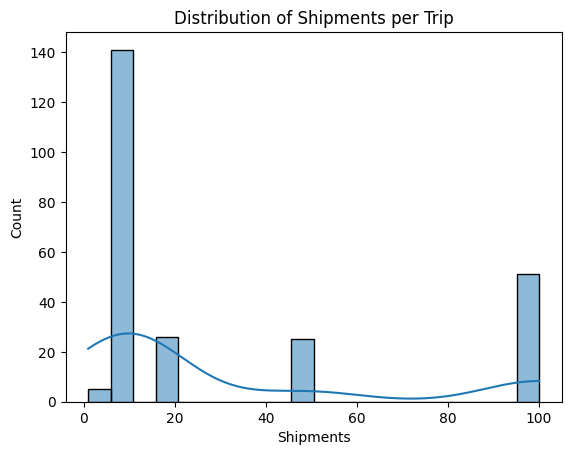

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(trip_summary["Shipments"], bins=20, kde=True)
plt.title("Distribution of Shipments per Trip")


Text(0.5, 1.0, 'MST Distance vs. Trip Time')

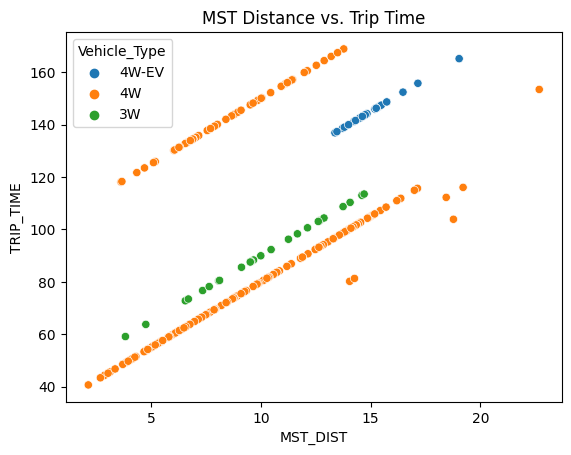

In [12]:
sns.scatterplot(data=trip_summary, x="MST_DIST", y="TRIP_TIME", hue="Vehicle_Type")
plt.title("MST Distance vs. Trip Time")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


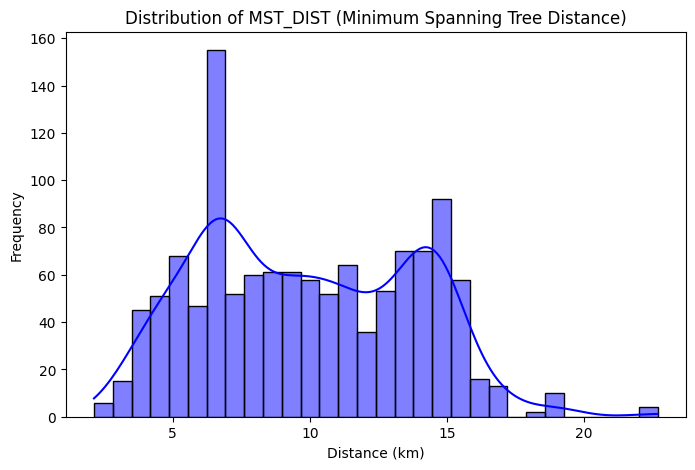

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(output_df["MST_DIST"].dropna(), bins=30, kde=True, color="blue")
plt.title("Distribution of MST_DIST (Minimum Spanning Tree Distance)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()


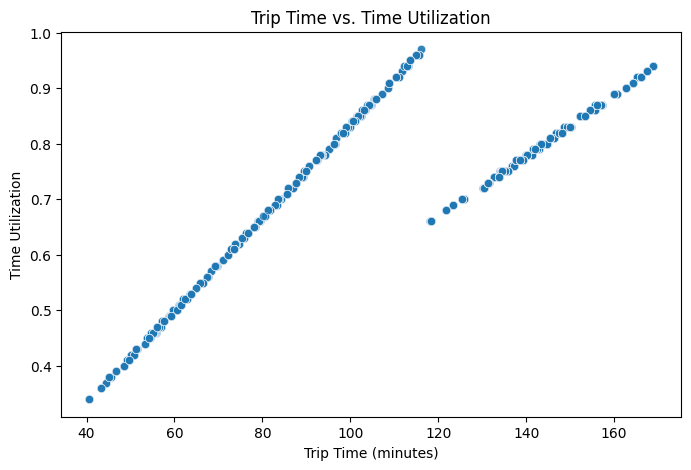

In [15]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=output_df, x="TRIP_TIME", y="TIME_UTI", alpha=0.7)
plt.title("Trip Time vs. Time Utilization")
plt.xlabel("Trip Time (minutes)")
plt.ylabel("Time Utilization")
plt.show()


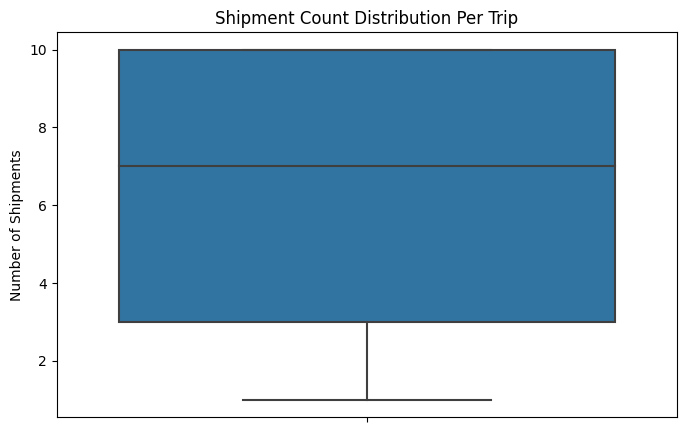

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=output_df, y="Shipments")
plt.title("Shipment Count Distribution Per Trip")
plt.ylabel("Number of Shipments")
plt.show()


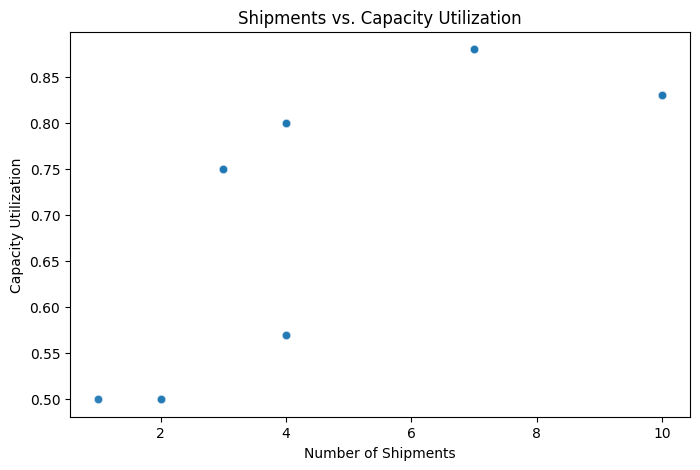

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=output_df, x="Shipments", y="CAPACITY_UTI", alpha=0.6)
plt.title("Shipments vs. Capacity Utilization")
plt.xlabel("Number of Shipments")
plt.ylabel("Capacity Utilization")
plt.show()
